In [41]:
# getting the flat field as in louis thesis + tutorial
# subsampled plots, run this overnight or something.

# but before that, get our imports done
import dLux as dl
import dLuxToliman as dlT
# gonna use normal numpy. jax numpy is weird. sike using jax
import numpy as np
from matplotlib import pyplot as plt
import dLux.utils as dlu
import jax
import jax.random as jr
import jax.numpy as jnp

# let's create the toliman pupil and obstructions, call it tolOptics

# might as well use 1024 pixels wavefront. nice and large number, prevent aliasing
wf_npixels = 1024

# smaller psf, only 10 sources. more than 18ish breaks on my macbook
psf_npixels = 128

# no need for oversampling
oversample = 1 # can change, put to 1 for normal toliman

# toliman pixel scale (arc seconds)
psf_pixel_scale = 0.375

# just for future use:
det_pixelsize = dlu.arcsec2rad(psf_pixel_scale/oversample)

tolOptics = dlT.TolimanOpticalSystem(wf_npixels, psf_npixels, oversample, psf_pixel_scale)

# now let's extract the pupil
tolPupil = tolOptics.pupil.opd

# make it a nice phase difference instead of OPD
tolPupilPhase = dlu.opd2phase(tolPupil, 585e-9) # it is pi phase difference for 585e-9 wavelength

# layer
tolPupilLayer = dl.layers.AberratedLayer(phase=tolPupilPhase)

# (normal toliman diameter)
diameter = 0.125

# initialsing coords for circular aperture
coords = dlu.pixel_coords(wf_npixels,diameter)

# x = np.arange(wf_npixels)
# y = np.arange(wf_npixels)
# X, Y = np.meshgrid(x,y, indexing = 'ij') # I believe the indexing part is neccessary? Anyway doesn't break anything

# creating the aperture (circular)
airyAperture = dlu.circle(coords,0.5 * diameter)

# making it a layer
airyApertureLayer = dl.layers.TransmissiveLayer(transmission=airyAperture, normalise=True)

# making the optical systems
tolPupilLayers = [
    (
        'aperture',
        airyApertureLayer
    ),
    (
        'pupil',
        tolPupilLayer
    )
]

airyApertureLayers = [
    (
        'aperture',
        airyApertureLayer
    )
]

tolPupilSystem = dl.AngularOpticalSystem(wf_npixels, diameter, tolPupilLayers, psf_npixels, psf_pixel_scale, oversample)

airyApertureSystem = dl.AngularOpticalSystem(wf_npixels, diameter, airyApertureLayers, psf_npixels, psf_pixel_scale, oversample)

# importing optax stuff
# Optimisation
import zodiax as zdx
import optax

from tqdm.notebook import tqdm


In [42]:
# modelling johson noise
# NOte: OVERSAMPLE SHOULD BE 1... unless.... we want 200% better pixel scale!!!
def bg_noise(dark_current, key): 
    noise_vals = (jnp.pi/2)**0.5*dark_current*jnp.abs(jr.normal(key, (psf_npixels*oversample,psf_npixels*oversample)))
    return noise_vals

# there is a 'addconstant' detector layer. but not sure how I can go from that to what I want.
# I think I just use it for modelling the mean value of detector noise.

In [43]:
idx = 0
# gonna try 10 sources close(r) together... 50 takes way too long... prone to breaking on my silly macbook.
n_sources = 10

# good maximum for 512 by 512 grid
max_pos = 20/oversample
positions_arcsecs = jr.uniform(jr.PRNGKey(idx), (n_sources, 2), minval=-max_pos, maxval=max_pos)
positions_rads = dlu.arcsec2rad(positions_arcsecs)

# fluxes from half-normal distribution, standard deviation 50,000 photons
fluxes = 50000*jnp.abs(jr.normal(jr.PRNGKey(idx), (n_sources,)))

# only 1 wavelength
wavelength = 585e-9 #mid(ish) point of toliman thing
wavelengths = wavelength * jnp.linspace(1, 1, 1)

sources = dl.PointSources(wavelengths,positions_rads,fluxes)

# adding the constant to model dark current... not working too well!
pix_response = jr.uniform(jr.PRNGKey(idx),[psf_npixels,psf_npixels],minval=0.8,maxval=1)


detector = dl.LayeredDetector([dl.layers.AddConstant(0),dl.layers.ApplyPixelResponse(pix_response)])

# random dithers! as described in louis thesis
dithers = det_pixelsize * jnp.array([[0, 0], [jr.uniform(jr.PRNGKey(idx),minval=-10,maxval=10), jr.uniform(jr.PRNGKey(idx+1),minval=-10,maxval=10)], [jr.uniform(jr.PRNGKey(idx+2),minval=-10,maxval=10), jr.uniform(jr.PRNGKey(idx+3),minval=-10,maxval=10)]])

print(dithers)

tolTelescope = dl.Dither(dithers,tolPupilSystem, sources, detector)
airyTelescope = dl.Dither(dithers,airyApertureSystem, sources, detector)

init_dark_current = 2 # just 2 the whole time here
# no poisson

# noise
tolData = tolTelescope.model() + jnp.array([bg_noise(init_dark_current, jr.PRNGKey(idx)),bg_noise(init_dark_current, jr.PRNGKey(idx+1)),bg_noise(init_dark_current, jr.PRNGKey(idx+2))])

model_positions = 'source.position'
model_fluxes = 'source.flux'

# don't know about this one
model_dark_current = 'detector.AddConstant.value'
model_pixel_response = 'detector.ApplyPixelResponse.pixel_response'

# params
parameters = [model_positions, model_fluxes, model_dark_current, model_pixel_response]

# just gonna do toliman for now
# plus/mins 0.5 pixels in each dimension. gonna assume uniform distribution because nothing mentioned

tolModel = tolTelescope.add(model_positions, jr.uniform(jr.PRNGKey(idx),(n_sources, 2),minval=-0.5*det_pixelsize,maxval=0.5*det_pixelsize))

# fluxes +/- 10%
tolModel = tolModel.multiply(model_fluxes, jr.uniform(jr.PRNGKey(idx), (n_sources,), minval=0.9, maxval=1.1))

# dark current +/-20%
tolModel = tolModel.add(model_dark_current, init_dark_current*jr.uniform(jr.PRNGKey(idx),1,minval=0.8,maxval=1.2))

# setting the pixel response
tolModel = tolModel.set(model_pixel_response, 0.9*jnp.ones((psf_npixels,psf_npixels)))

# this stuff really depends on how many sources you have
pos_optimiser   = optax.adam(7e-9) # good value
flux_optimiser  = optax.adam(200) # good value
current_optimiser = optax.adam(0.02*0.2*init_dark_current)

# Now the flat-field, because it is highly covariant with the mean flux level
# we don't start learning its parameters until the 400th epoch.
FF_sched = optax.piecewise_constant_schedule(init_value=1e-2*1e-8, 
                             boundaries_and_scales={400 : int(1e8)})
FF_optimiser = optax.adam(FF_sched)

optimisers = [pos_optimiser, flux_optimiser, current_optimiser, FF_optimiser]

optim, opt_state = zdx.get_optimiser(tolModel, parameters, optimisers)

@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def loss_fn(model, data):
    out = model.model()
    return jnp.sum((data-out)**2)

losses, models_out = [], []
min_iters = 1000  # Ensure at least 1000 iterations are completed before checking
threshold = 0.001  # 0.1% change threshold

losses, models_out = [], []
with tqdm(range(1000),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(tolModel, tolData)    
        updates, opt_state = optim.update(grads, opt_state)
        tolModel = zdx.apply_updates(tolModel, updates)
        losses.append(loss)
        models_out.append(tolModel)
        # Compute log loss and update progress bar
        log_loss = jnp.log10(loss)
        t.set_description("Log Loss: {:.3f}".format(log_loss)) 
        if jnp.isnan(loss):
            break
        # Check for early stopping after at least 100 iterations
        if i >= min_iters:
            recent_losses = jnp.log10(jnp.array(losses[-100:]))  # Last 100 losses
            initial_loss = jnp.log10(recent_losses[0])
            final_loss = jnp.log10(recent_losses[-1])
            
            if jnp.abs(final_loss - initial_loss) / initial_loss < threshold:
                print(f"Early stopping at iteration {i} as log loss change is below {threshold * 100}%.")
                break




[[ 0.0000000e+00  0.0000000e+00]
 [ 1.6277632e-05 -2.2313857e-06]
 [ 5.1193074e-06 -1.5487885e-05]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
nepochs = len(models_out)
psfs_out = models_out[-1].model()

positions_found  = jnp.array([model.get(model_positions) for model in models_out])
fluxes_found     = jnp.array([model.get(model_fluxes)    for model in models_out])
current_found = jnp.array([model.get(model_dark_current) for model in models_out])
flatfields_found = jnp.array([model.get(model_pixel_response) for model in models_out])


flux_residuals = fluxes - fluxes_found
current_residuals = init_dark_current - current_found

#scaler = 1e3
positions_residuals = positions_rads - positions_found
r_residuals_rads = np.hypot(positions_residuals[:, :, 0], positions_residuals[:, :, 1])
r_residuals = dlu.rad2arcsec(r_residuals_rads)


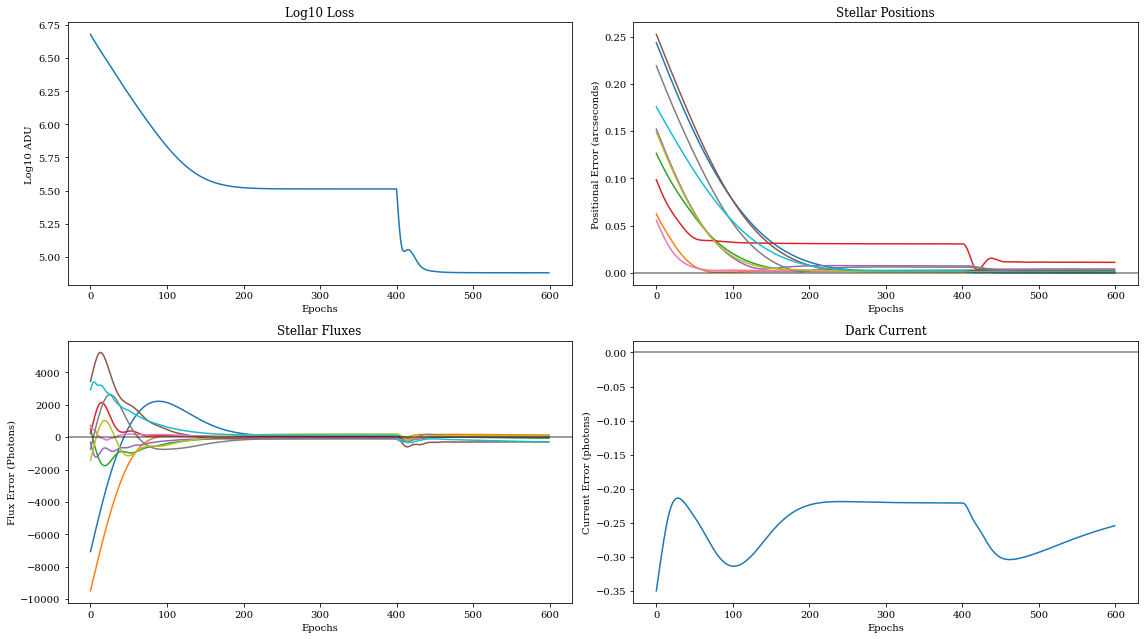

In [45]:
%matplotlib inline
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

j = len(models_out)
plt.figure(figsize=(16, 13))

plt.subplot(3, 2, 1)
plt.title("Log10 Loss")
plt.xlabel("Epochs")
plt.ylabel("Log10 ADU")
plt.plot(np.log10(np.array(losses)[:j]))

plt.subplot(3, 2, 2)
plt.title("Stellar Positions")
plt.xlabel("Epochs")
plt.ylabel("Positional Error (arcseconds)")
plt.plot(r_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 3)
plt.title("Stellar Fluxes")
plt.xlabel("Epochs")
plt.ylabel("Flux Error (Photons)")
plt.plot(flux_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 4)
plt.title("Dark Current")
plt.xlabel("Epochs")
plt.ylabel("Current Error (photons)")
plt.plot(current_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.tight_layout()
plt.show()

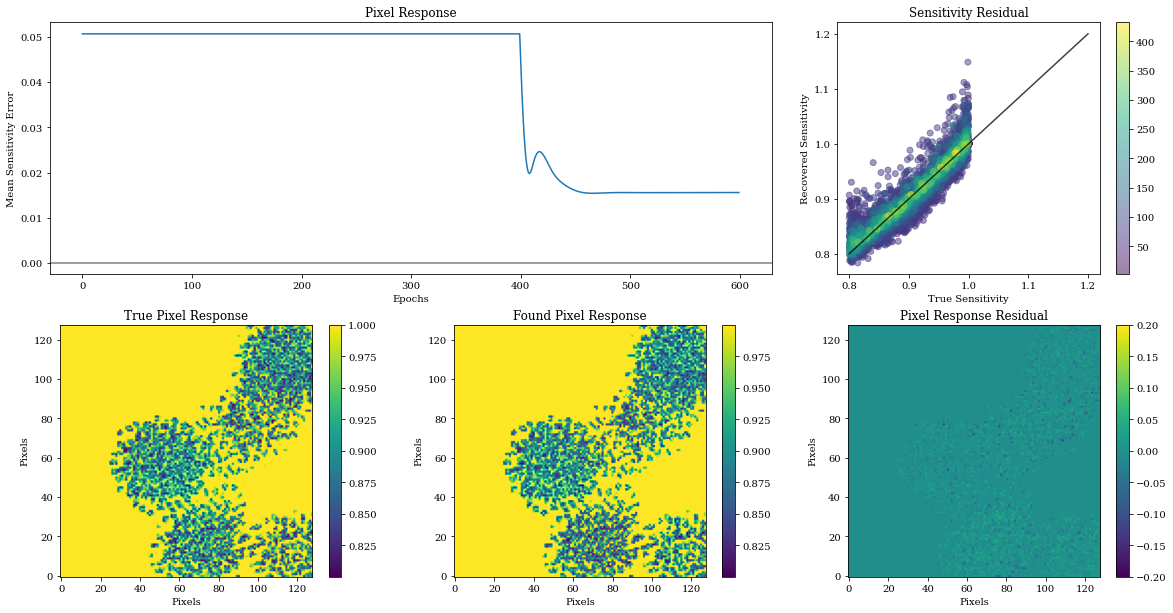

In [53]:
# calculate the mask where there was enough flux to infer the flat field
thresh = 20
fmask = tolData.mean(0) >= thresh

out_mask = np.where(tolData.mean(0) < thresh)
in_mask = np.where(tolData.mean(0) >= thresh)

data_tile = np.tile(tolData.mean(0), [len(models_out), 1, 1])
in_mask_tiled = np.where(data_tile >= thresh)

# calculate residuals
pr_residuals = pix_response[in_mask] - flatfields_found[-1][in_mask]

# for correlation plot
true_pr_masked = pix_response.at[out_mask].set(1)
found_pr_masked = flatfields_found[-1].at[out_mask].set(1)

# FF Scatter Plot
data_sum = tolData.sum(0) # [flux_mask]
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]

pr_true_flat = true_pr_masked.flatten()
pr_found_flat = found_pr_masked.flatten()

pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

# Errors
pfound = flatfields_found[in_mask_tiled].reshape([len(models_out), len(in_mask[0])])
ptrue = pix_response[in_mask]
pr_res = ptrue - pfound
masked_error = np.abs(pr_res).mean(-1)

plt.figure(figsize=(20, 10))
plt.subplot(2, 3, (1,2))
plt.title("Pixel Response")
plt.xlabel("Epochs")
plt.ylabel("Mean Sensitivity Error")
plt.plot(masked_error)
plt.axhline(0, c='k', alpha=0.5)

# FF Scatter Plot
data_sum = tolData.sum(0)
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]

pr_true_flat = true_pr_masked.flatten()
pr_found_flat = found_pr_masked.flatten()

pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

plt.subplot(2, 3, 3)
plt.plot(np.linspace(0.8, 1.2), np.linspace(0.8, 1.2), c='k', alpha=0.75)
plt.scatter(pr_true_sort, pr_found_sort, c=colours, alpha=0.5)
plt.colorbar()
plt.title("Sensitivity Residual")
plt.ylabel("Recovered Sensitivity")
plt.xlabel("True Sensitivity")

plt.subplot(2, 3, 4)
plt.title("True Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr_masked)
plt.colorbar()

vmin = np.min(pix_response)
vmax = np.max(pix_response)

plt.subplot(2, 3, 5)
plt.title("Found Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(found_pr_masked, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("Pixel Response Residual")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr_masked - found_pr_masked, vmin=-0.2, vmax=0.2)
plt.colorbar()

plt.show()

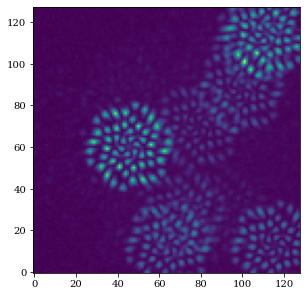

In [30]:
plt.imshow(tolData[0])